# Evaluate Performance of Models with Large Molecules
As part of another study, we computed the G4MP2 energies of a few hundred large molecules. Here, we test whether the models trained on QM9 can successfully predict the energies of the large molecules given...

- B3LYP coordinates
- B3LYP coordinates and energy
- Without coordinates or energies

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.coordinates import generate_atomic_coordinates, get_rmsd
from jcesr_ml.schnetpack import load_model, run_model
from jcesr_ml.qml import run_model as run_qml_model
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.style import model_style
from ase.units import Hartree, eV
from pymatgen.io.xyz import XYZ
from pymatgen import Element
from io import StringIO
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os

Directories with fully-trained models

In [2]:
schnet_dir = os.path.join('..', 'benchmark', 'schnet')
fchl_dir = os.path.join('..', 'benchmark', 'qml')

## Read in the Sugar Data
We saved it to a JSON file in a previous notebook. Get only the molecules larger than our training set

In [3]:
data = pd.read_json(os.path.join('..', 'data', 'output', 'sugar_data.json'), lines=True)
print('Read data of {} molecules'.format(len(data)))

Read data of 66 molecules


Print the error of B3LYP to G4MP2

In [4]:
print('Total number of molecules: {} - B3LYP MAE: {:.1f} meV'.format(len(data), (data['u0_atom'] - data['g4mp2_atom']).abs().mean() * Hartree / eV * 1000))

Total number of molecules: 66 - B3LYP MAE: 439.1 meV


## Given B3LYP Coordinates
Emulate what happens if we have a perfect guess of the B3LYP coordinates, but did not measure the energy

### Evaluate SchNet Models
Use the `stacked-delta` model (the best-performing modification) and baseline SchNet

In [5]:
for m in ['g4mp2-transfer', 'g4mp2-stacked-delta', 'g4mp2']:
    model = load_model(m, 117232, arch_dir=schnet_dir, weights_dir=schnet_dir)
    data['g4mp2_0k-pred-{}'.format(m)] = run_model(model, data, 'xyz')

### Evaluate FCHL Models
Pick the ones trained on the most data

In [6]:
%%time
for m in ['fchl']:
    with gzip.open(os.path.join(fchl_dir, '{}_g4mp2.pkl.gz'.format(m)), 'rb') as fp:
        model = pkl.load(fp)
    data['g4mp2_0k-pred-fchl'] = run_qml_model(model, data, 'xyz')

CPU times: user 1h 13min 22s, sys: 8.08 s, total: 1h 13min 31s
Wall time: 19min 20s


### Compare the Results
Show the distribution of errors, which will be a more meaningful plot than a predictive-vs-actual plot due to the small sizes for the errors compared to the true values.

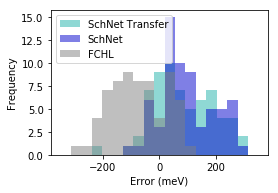

In [7]:
fig, ax = plt.subplots()

bins = np.linspace(-350, 350, 20)

# Plot the SchNet models
for m in ['g4mp2-transfer', 'g4mp2']:
    error = (data['g4mp2_0k-pred-{}'.format(m)] - data['g4mp2_0k']) * Hartree / eV * 1000
    ax.hist(error, bins=bins, alpha=0.5, color=model_style[m]['color'],
           label=model_style[m]['label'])
    
# Plot FCHL
error = (data['g4mp2_atom'] - data['g4mp2_0k-pred-fchl']) * Hartree / eV * 1000
ax.hist(error, bins=bins, alpha=0.5, color=model_style['FCHL']['color'],
           label=model_style['FCHL']['label'])

# Make it pretty
ax.set_xlabel('Error (meV)')
ax.set_ylabel('Frequency')

ax.legend()
fig.tight_layout()
fig.set_size_inches(3.5, 2.5)

SchNet MAE 110.81081301338736
FCHL MAE 103.09173699978612


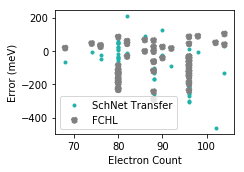

In [8]:
fig, ax = plt.subplots()

bins = np.linspace(-2000, 2000, 20)

# Add in the SchNet stacked
error = (data['g4mp2_0k'] - data['g4mp2_0k-pred-g4mp2-transfer']) * Hartree / eV * 1000
print('SchNet MAE', error.abs().mean())
ax.scatter(data['n_electrons'], error, **model_style['g4mp2-transfer'])


# Add in the FCHL
error = (data['g4mp2_atom'] - data['g4mp2_0k-pred-fchl']) * Hartree / eV * 1000
print('FCHL MAE', error.abs().mean())
ax.scatter(data['n_electrons'], error, **model_style['FCHL'])

# Make it pretty
ax.set_xlabel('Electron Count')
ax.set_ylabel('Error (meV)')

ax.legend()

fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'large-molecule-errors.png'), dpi=320)

*Finding*: There seem to be some types of molecules that are especially problematic. We should dig in to what these are and figure out what is going on.

## B3LYP Coordinates and Energies
Measure the performance of the models using the B3LYP coordinates and energy

### Evaluate SchNet Models
Use the `delta` model

In [9]:
for m in ['g4mp2-delta']:
    model = load_model(m, 117232, arch_dir=schnet_dir, weights_dir=schnet_dir)
    data['g4mp2_0k-pred-{}'.format(m)] = run_model(model, data, 'xyz', ['u0'])

### Evaluate FCHL Models
Evaluate the Delta model trained on the largest dataset

In [10]:
%%time
with gzip.open(os.path.join(fchl_dir, 'fchl_g4mp2-delta.pkl.gz'), 'rb') as fp:
    model = pkl.load(fp)
data['g4mp2_0k-pred-{}'.format('fchl-delta')] = run_qml_model(model, data, 'xyz')

CPU times: user 1h 12min 49s, sys: 6.31 s, total: 1h 12min 55s
Wall time: 18min 52s


## Compare the Methods
Mkae a histogram so that we can see the distributions of errors

MAE B3LYP: 439.12 meV
MAE g4mp2-delta: 39.46 meV
MAE FCHL Delta: 19.70 meV


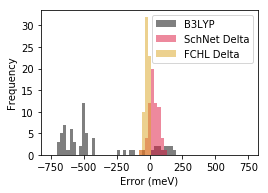

In [11]:
fig, ax = plt.subplots()

bins = np.linspace(-750, 750, 64)

# Plot B3LYP
error = (data['g4mp2_atom'] - data['u0_atom']) * Hartree / eV * 1000
print('MAE B3LYP: {:.2f} meV'.format(error.abs().mean()))
ax.hist(error, bins=bins, alpha=0.5, color=model_style['B3LYP']['color'],
       label=model_style['B3LYP']['label'])


# Plot the SchNet models
for m in ['g4mp2-delta']:
    error = (data['g4mp2_0k-pred-{}'.format(m)] - data['g4mp2_0k']) * Hartree / eV * 1000
    print('MAE {}: {:.2f} meV'.format(m, error.abs().mean()))
    ax.hist(error, bins=bins, alpha=0.5, color=model_style[m]['color'],
           label=model_style[m]['label'])
    
# Add FCHL
error = (data['g4mp2_atom'] - data['u0_atom'] - data['g4mp2_0k-pred-fchl-delta']) * Hartree / eV * 1000
print('MAE {}: {:.2f} meV'.format('FCHL Delta', error.abs().mean()))
ax.hist(error, bins=bins, alpha=0.5, color=model_style['FCHL Delta']['color'],
       label=model_style['FCHL Delta']['label'])

# Make it pretty
ax.set_xlabel('Error (meV)')
ax.set_ylabel('Frequency')

ax.legend()
fig.tight_layout()
fig.set_size_inches(3.5, 2.5)

MAE B3LYP: 439.12 meV
MAE g4mp2-delta: 39.46 meV
MAE FCHL Delta: 19.70 meV


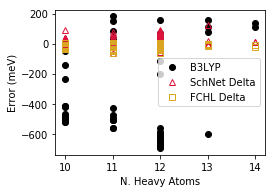

In [12]:
fig, ax = plt.subplots()

# Plot B3LYP
error = (data['g4mp2_atom'] - data['u0_atom']) * Hartree / eV * 1000
print('MAE B3LYP: {:.2f} meV'.format(error.abs().mean()))
ax.plot(data['n_heavy_atoms'], error, **model_style['B3LYP'], linewidth=0)


# Plot the SchNet models
for m in ['g4mp2-delta']:
    error = (data['g4mp2_0k-pred-{}'.format(m)] - data['g4mp2_0k']) * Hartree / eV * 1000
    print('MAE {}: {:.2f} meV'.format(m, error.abs().mean()))
    ax.plot(data['n_heavy_atoms'], error, **model_style[m], linewidth=0)
    
# Add FCHL
error = (data['g4mp2_atom'] - data['u0_atom'] - data['g4mp2_0k-pred-fchl-delta']) * Hartree / eV * 1000
print('MAE {}: {:.2f} meV'.format('FCHL Delta', error.abs().mean()))
ax.plot(data['n_heavy_atoms'], error, **model_style['FCHL Delta'], linewidth=0)

# Make it pretty
ax.set_ylabel('Error (meV)')
ax.set_xlabel('N. Heavy Atoms')

ax.legend()
fig.tight_layout()
fig.set_size_inches(3.5, 2.5)

## No Coordinates or Energies
We just use the atomic coordinates generated from OpenBabel

In [13]:
%%time
data['xyz_gen'] = data['smiles'].apply(generate_atomic_coordinates)

CPU times: user 51 s, sys: 15.6 ms, total: 51 s
Wall time: 51.3 s


See how good the predictions are

In [14]:
%%time
data['rmsd'] = data.apply(lambda x: get_rmsd(x['xyz'], x['xyz_gen']), axis=1)

CPU times: user 2.47 s, sys: 0 ns, total: 2.47 s
Wall time: 2.48 s


In [15]:
data['rmsd'].describe()

count    66.000000
mean      1.186018
std       0.881268
min       0.029167
25%       0.545417
50%       1.140122
75%       1.980044
max       3.392658
Name: rmsd, dtype: float64

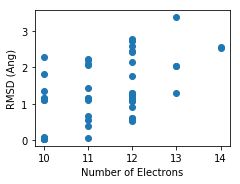

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['n_heavy_atoms'], data['rmsd'])

ax.set_ylabel('RMSD (Ang)')
ax.set_xlabel('Number of Electrons')

fig.set_size_inches(3.5, 2.5)

*Finding*: The RMSD between B3LYP and our generated coordinates is enormous.

## Evaluate the Re-trained SchNet
We are going to use the one trained on conformers with a jitter of 0.1 Å

In [17]:
model = load_model('g4mp2-transfer', 'relaxed-conformers', '0.1000', arch_dir=schnet_dir,
                  weights_dir=os.path.join('..', 'coordinate-sensitivity'))

In [18]:
data['g4mp2_0k-pred-schnet-smiles'] = run_model(model, data, 'xyz_gen')

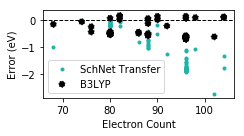

In [19]:
fig, ax = plt.subplots()


# Plot the SchNet Predictions
error = (data['g4mp2_0k'] - data['g4mp2_0k-pred-schnet-smiles']) * Hartree / eV
ax.scatter(data['n_electrons'], error, **model_style['g4mp2-transfer'])

error = (data['g4mp2_atom'] - data['u0_atom']) * Hartree / eV
ax.scatter(data['n_electrons'], error, **model_style['B3LYP'])

# Add in the zero line
xlim = ax.set_xlim(ax.get_xlim())
ax.plot(xlim, [0,0], 'k--', lw=1)

ax.legend(loc='lower left')

# Make it pretty
ax.set_xlabel('Electron Count')
ax.set_ylabel('Error (eV)')

fig.set_size_inches(3.5, 2)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'large-molecules-generated.png'), dpi=320)

*Finding*: The model accuracy when using conformers severely degrades with atomic size. Our largest molecules have errors of nearly 1 eV, which is likely too large to be useful.

## Save the Data
Save the data for later plotting

In [20]:
data.to_csv('large-molecule-predictions.csv', index=False)